# Capstone Project - Analysis of the Corona pandemic
In this project, the data from the ongoing "Corona" pandemic is analyzed. The SARS-CoV-2 virus has spread around the world in a relatively short time after its first apperance in Wuhan (China) and the caused disease COVID-19 (=coronavirus disease 2019) stresses the healthcare systems in many countries. Here it is analyzed what are the driving forces for the exponential growths rates and how effective are the measures against.

Therefor, two datasets are analyzed:

1. One dataset has been taken from the CSSE at Johns Hopkins University: It shows timeseries regarding cumulative Corona cases of all affacted countries. The data has been taken from the following GitHub repository. Please note, that the data is updated every day. Thus, there might be effects on the conclusion in a few weeks. For this analysis, data taken on April 14th has been used (stored in DataScience_Project4 GitHub): https://github.com/CSSEGISandData/COVID-19/edit/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

2. Another dataset has been downloaded from Kaggle. It gives an overview on different Corona-related information for the affected countries: https://www.kaggle.com/koryto/countryinfo#covid19countryinfo.csv

## 1. Questions
The main questions are:
1. What are the effects of the initial situation in the different countries on the exponential growth rate?
2. What are the effects of the different measures to contain the disease?

To answer these questions, it is - after a general data understanding - checked for correlations between measures in the data. In a second step it is checked whether it is possible to predict growth and containment.


## 2. Data understanding
The data is loaded and a number of things are checked to understand the datasets.


In [1]:
# Import standard packages
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

# Import additional packages
from scipy.signal import savgol_filter # Implements specific filter (Savitzky-Golay) to smooth statistical fluctuations
import capstone_support_functions as capstone

# Import helper functions stored in 

# Set output options in a way that all columns and rows of the used datasets are visible
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 1000)

df_timeseries = pd.read_csv('./time_series_covid19_confirmed_global.csv') # Read in timeseries data
df_countryinfo = pd.read_csv('./covid19countryinfo.csv') # Read in country information data

#df_tests = pd.read_csv('./covid19tests.csv') # Read in data

### Check the timeseries data

In [2]:
# Show the timeseries data
df_timeseries

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7,7,7,7,9,15,15,15,15,19,19,19,19,21,21,23,23
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265,1451,1451,1554,1628,1715,1795,1975,1975,2142,2208,2277
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736,770,822,833,853,881,921,937,967,1013,1039,1067
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77,78,80,84,87,91,93,96,96,96,99,100,103,103,103,102,103
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389,2493,2580,2637,2686,2734,2773,2822,2857,2857,2863,2870


In [3]:
print('The dataset contains', df_timeseries.shape[0], 'rows and', df_timeseries.shape[1], 'columns.')

The dataset contains 264 rows and 88 columns.


The timeseries contains the number of Corona cases for 258 countries/regions for a time period beginning on January 22, 2020. In some cases, there is a differentiation between different provinces/states of a country. Furthermore, the latitutde and longitude of the countries are shown.

In the next step, the number of cases are plotted. Thereby, the 20 countries with the highest number of cases at the end of the timeseries are shown.

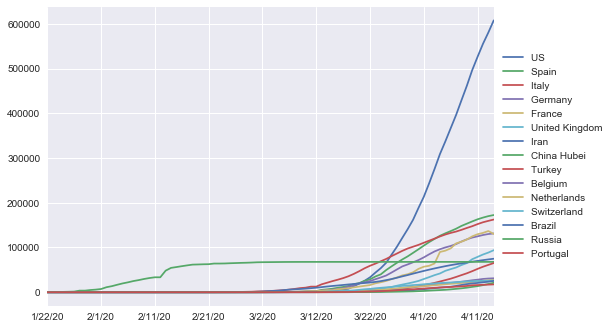

In [4]:
# Sort the timeseries according the number of cases in the last column (last known day)
df_sorted=df_timeseries.sort_values(by=df_timeseries.columns[-1], ascending=False)

# Select the first rows which shall be plot
df_sorted=df_sorted.head(15)

# Remove nan values
df_sorted['Province/State'].fillna("", inplace=True)

# Add a column country that combines Country/Region and Province/State
df_sorted['Country']=df_sorted['Country/Region']+" "+df_sorted['Province/State']

# Define the country column as the new index (later on shown in the plot legend)
df_sorted.set_index('Country', inplace=True)

# Delete columns which are not needed for the plot
del df_sorted['Country/Region']
del df_sorted['Province/State']
del df_sorted['Lat']
del df_sorted['Long']
        
# Exchange rows and columns which is required for the plot function (in line charts columns are plotted)
df_sorted=df_sorted.transpose()
    
# Create plot
plt.style.use('seaborn') # Define style  
df_sorted.plot(kind='line', legend=True, logy=False, mark_right=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # Show legend outside of the plot
plt.show()

The plot above shows the typical chart maybe known from news coverage. It shows typical exponential growth curves for most of the countries. After some days, the growth seems to change to a more linear growth. Two curves have a very specific shape. The US curves shows the highest growth rate while for China the growth has stopped after a second steep increase mid of February.

### Check the country information data

In [5]:
# Show countryinfo
df_countryinfo

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,publicplace,gatheringlimit,gathering,nonessential,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity,firstcase,totalcases,active30,active31,active1,active2,active3,newcases30,newcases31,newcases1,newcases2,newcases3,deaths,newdeaths30,newdeaths31,newdeaths1,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m
0,NaN,Afghanistan,AFG,AF,"38,928,346",NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5000,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333,2/23/2020,273,139,165,187,225,257,25,4,22,2,NaN,6,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,7,0.20
1,NaN,Albania,ALB,AL,"2,877,797",NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9000,29.40,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04,"15,418",774,268.955733,1.51,13.950000,69.900000,3/7/2020,304,168,176,177,194,199,11,20,16,18,27,16,1.0,4.0,NaN,1.0,NaN,89,7,8,7,7,7,106,6.00
2,NaN,Algeria,DZA,DZ,"43,851,044",NaN,NaN,18.0,29.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,1.9000,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81,"172,781","1,031",23.511413,2.70,19.566667,61.716667,2/24/2020,986,449,626,728,728,839,NaN,132,131,NaN,NaN,86,NaN,9.0,14.0,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,22,2.00
3,NaN,Andorra,AND,AD,"77,265",NaN,NaN,164.0,45.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5000,32.50,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN,"91,527","5,949",76994.758300,1.40,7.383333,75.233333,3/1/2020,439,322,352,366,403,407,NaN,NaN,14,38,11,16,NaN,NaN,2.0,1.0,1.0,16,10,10,12,12,12,"5,682",207.00
4,NaN,Antigua and Barbuda,ATG,AG,"97,929",NaN,NaN,223.0,34.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8000,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78,"1,688","1,105",11283.685120,2.00,NaN,NaN,3/12/2020,9,7,7,7,7,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,NaN
5,NaN,Argentina,ARG,AR,"45,195,774",NaN,NaN,17.0,32.0,93.0,3/20/2020,NaN,NaN,NaN,NaN,NaN,5.0000,23.95,1.05,1.06,1.05,1.00,0.94,0.71,0.98,29.27,20.16,42.59,"445,469","1,390",30.755088,2.26,32.816667,43.616667,3/2/2020,"1,265",570,700,778,851,970,NaN,146,NaN,NaN,NaN,39,2.0,3.0,1.0,2.0,3.0,256,NaN,NaN,NaN,NaN,NaN,28,0.90
6,NaN,Armenia,ARM,AM,"2,963,243",694.0,4269.802594,104.0,35.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,4.2000,26.90,1.13,1.14,1.06,0.93,0.84,0.67,0.94,23.86,16.17,35.99,"13,444",883,297.984337,1.64,7.100000,58.500000,2/29/2020,736,449,499,536,625,686,58,50,39,92,73,7,NaN,NaN,1.0,1.0,NaN,43,15,30,30,30,30,248,2.00
7,Aruba,Netherlands,ABW,AW,"106,766",NaN,NaN,593.0,41.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,1.2000,NaN,1.02,1.01,1.01,0.93,0.87,0.64,0.90,NaN,NaN,NaN,"2,903",43,402.749939,1.83,26.533333,80.166667,3/12/2020,60,49,54,54,54,59,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,562,NaN
8,NaN,Australia,AUS,AU,"25,499,884",31635.0,806.065560,3.0,38.0,86.0,NaN,NaN,3/23/2020,2.0,3/29/2020,NaN,3.8000,14.90,1.06,1.06,1.09,0.99,0.93,0.86,0.99,18.79,15.90,22.16,"1,376,255","4,492",176.157664,1.77,25.783333,64.233333,1/24/2020,"5,350","3,983","4,205","4,498","4,767","4,737",82,101,101,89,36,28,1.0,NaN,1.0,2.0,3.0,585,28,28,50,50,85,210,1.00
9,NaN,Austria,AUT,AT,"9,006,398",10278.0,876.279237,109.0,43.0,57.0,3/16/2020,NaN,NaN,NaN,NaN,NaN,7.6000,35.15,1.05,1.05,1.04,1.00,0.98,0.76,0.96,17.02,13.02,22.14,"447,718","5,138",570.483339,1.47,9.466667,65.350000,2/24/2020,"11,444","8,710","8,886","9,003","9,120","9,254",666,491,405,316,315,168,22.0,20.0,18.0,12.0,10.0,"2,022",193,198,215,227,245,"1,271",19.00


In [6]:
# Get an overview on the dataset
df_countryinfo.describe()

,tests,testpop,density,medianage,urbanpop,gatheringlimit,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,healthperpop,fertility,avgtemp,avghumidity,newdeaths30,newdeaths31,newdeaths1,newdeaths2,newdeaths3,deathdiv1m
count,52.000000,52.000000,187.000000,187.000000,187.000000,32.000000,186.000000,123.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,186.000000,164.000000,164.000000,164.000000,183.000000,185.000000,152.000000,152.000000,56.000000,66.000000,68.000000,67.000000,56.000000,135.000000
mean,30192.903846,22281.534633,412.743316,32.084492,64.087166,98.281250,3.299401,21.986992,1.051390,1.045989,1.050107,1.043422,0.959679,0.796952,1.007204,24.505549,18.920122,32.088841,2355.124042,2.482649,19.312829,67.653838,22.910714,52.651515,47.617647,45.477612,45.767857,18.720593
std,65479.055781,67986.836475,2083.936842,9.455375,22.164482,218.532973,2.806039,9.005344,0.026664,0.030311,0.133025,0.345960,0.261363,0.155203,0.207092,15.475574,13.932863,19.537331,11877.522514,1.221939,10.899411,14.499465,76.898818,146.624113,140.513348,139.384291,135.124991,83.240696
min,500.000000,35.588092,0.000000,15.200000,15.000000,2.000000,0.100000,3.700000,0.940000,0.970000,0.830000,0.710000,0.580000,0.450000,0.840000,6.290000,0.690000,9.210000,0.172463,0.200000,-9.883333,10.983333,1.000000,1.000000,1.000000,1.000000,1.000000,0.010000
25%,1505.500000,794.582044,35.500000,24.700000,46.500000,10.000000,1.300000,15.150000,1.035000,1.030000,1.010000,0.970000,0.870000,0.715000,0.960000,16.320000,10.902500,21.540000,11.883978,1.690000,9.708333,62.200000,1.000000,1.000000,1.000000,2.000000,1.000000,0.300000
50%,5950.000000,2811.814632,94.000000,32.000000,66.000000,10.000000,2.600000,22.450000,1.050000,1.050000,1.040000,1.010000,0.950000,0.790000,0.990000,21.295000,16.485000,26.865000,89.112200,2.000000,20.525000,72.425000,3.000000,4.000000,3.500000,3.000000,4.000000,1.000000
75%,16121.000000,5943.719566,233.000000,40.000000,83.000000,50.000000,4.575000,27.350000,1.060000,1.060000,1.060000,1.035000,0.995000,0.860000,1.010000,27.117500,23.050000,34.890000,465.193200,2.820000,28.283333,77.945833,6.000000,13.000000,14.000000,10.000000,10.250000,6.000000
max,320000.000000,415993.107300,26337.000000,62.000000,100.000000,1000.000000,14.353400,42.650000,1.260000,1.170000,2.640000,4.910000,3.380000,1.710000,3.410000,114.280000,94.590000,174.880000,108308.036900,6.950000,40.150000,92.316667,537.000000,837.000000,727.000000,760.000000,684.000000,884.000000


The first check shows that the meanings of country and region columns are different in the countryinfo dataset in comparison to the timeseries set. Thus, some data preparation is required to combine the data. Furthermore, the countryinfo dataset contains many fields with "nan" and the colums for population ("pop"), GDP ("gdp2019"), and health expenses ("healthexp") are not interpreted as a number. Additionally, the columns for the number of tests and the test population are, unfortunately, outdated since the description of the dataset shows that these numbers have been updated on March 24, 2020. Thus, they will not be used in the following analysis. There are also some information on detected cases per day. However, these information are taken from the other dataset.

In the follwing cells some information contained in the data are visualized to get a better overview on some details that might be helpful to answer the questions above.

Text(0, 0.5, 'Frequency')

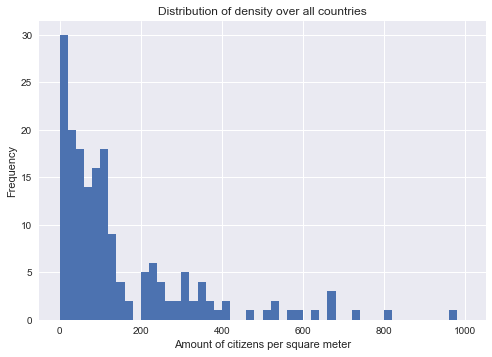

In [53]:
# Create a histogram of the density distribution
df_countryinfo['density'].hist(bins=50, range=(0, 1000))
plt.title("Distribution of density over all countries")
plt.xlabel('Amount of citizens per square meter')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

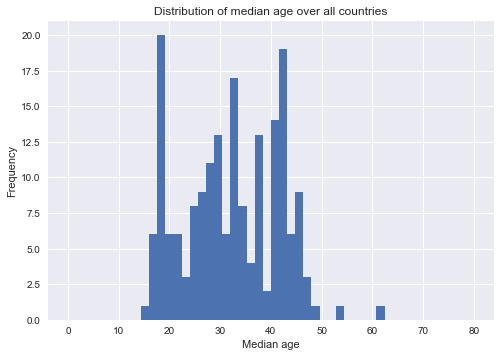

In [58]:
# Create a histogram of the median age distribution
df_countryinfo['medianage'].hist(bins=50, range=(0, 80))
plt.title("Distribution of median age over all countries")
plt.xlabel('Median age')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

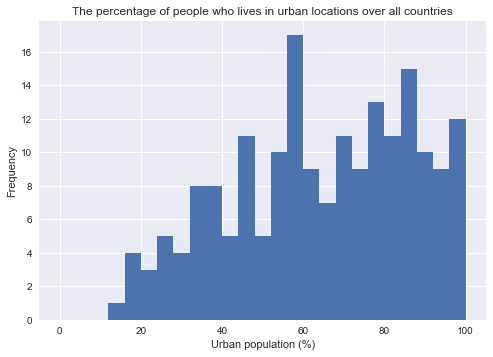

In [79]:
# Create a histogram of the percentage of people who lives in urban locations
df_countryinfo['urbanpop'].hist(bins=25, range=(0, 100))
plt.title("The percentage of people who lives in urban locations over all countries")
plt.xlabel('Urban population (%)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

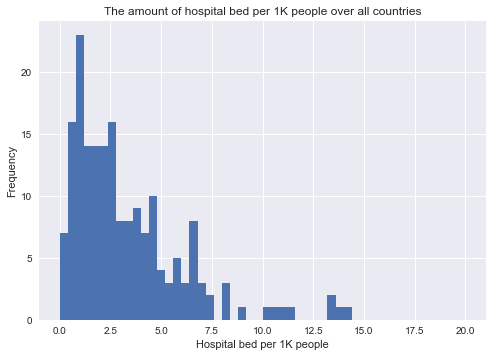

In [80]:
# Create a histogram of the amount of hospital bed per 1K people
df_countryinfo['hospibed'].hist(bins=50, range=(0, 20))
plt.title("The amount of hospital bed per 1K people over all countries")
plt.xlabel('Hospital bed per 1K people')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

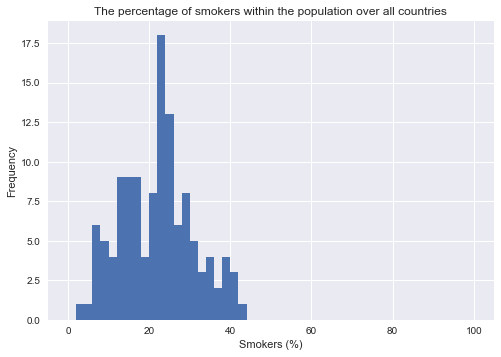

In [67]:
# Create a histogram of the % of smokers within the population.
df_countryinfo['smokers'].hist(bins=50, range=(0, 100))
plt.title("The percentage of smokers within the population over all countries")
plt.xlabel('Smokers (%)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

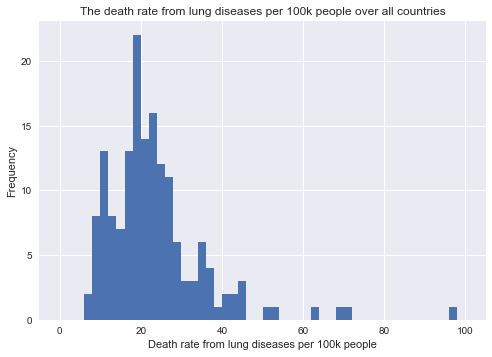

In [81]:
# Create a histogram of the death rate from lung diseases per 100k people
df_countryinfo['lung'].hist(bins=50, range=(0, 100))
plt.title("The death rate from lung diseases per 100k people over all countries")
plt.xlabel('Death rate from lung diseases per 100k people')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

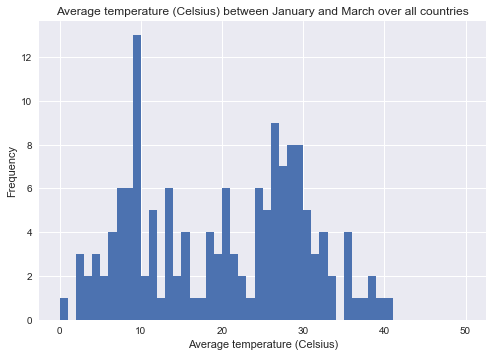

In [82]:
# Create a histogram of the average temperature (Celsius) between January and March 
df_countryinfo['avgtemp'].hist(bins=50, range=(0, 50))
plt.title("Average temperature (Celsius) between January and March over all countries")
plt.xlabel('Average temperature (Celsius)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

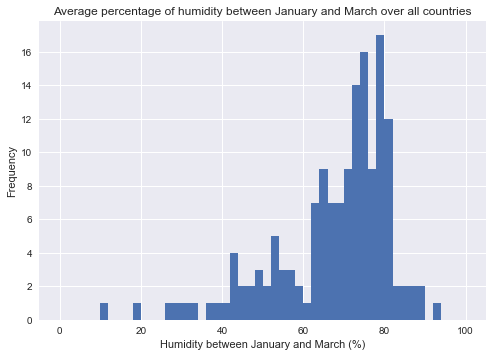

In [83]:
# Create a histogram of the average percentage of humidity between January and March
df_countryinfo['avghumidity'].hist(bins=50, range=(0, 100))
plt.title("Average percentage of humidity between January and March over all countries")
plt.xlabel('Humidity between January and March (%)')
plt.ylabel('Frequency')

It shall be checked later on whether the plotted measures have an effect on the exponentual growth rate of the outbreaks. Furthermore, the table contains other information like dates when specifc measures against the disease have been started, e.g. school closure policy. These dates might help to analyse the containment effects.

## 3. Data preparation
### Timeseries dataset
The timeseries set contains columns for each day from Januray 22,2020 to show the number of cases for each country/region (as plotted above). The start dates of the outbreaks in the different countries/regions were very different. In order to compare them, the first step is to normalize everything to a "day 1" which is the day when a specific number of cases have been detected in each individual country. After that it would be possible to compare the overlaying curves.

#### Create timeseries dataset to overlay the rates of increase for all countries

In [12]:
df_timeseries['Province/State'].fillna("", inplace=True)

In [13]:
df_timeseries.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714
1,,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475
2,,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
3,,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659
4,,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19
5,,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7,7,7,7,9,15,15,15,15,19,19,19,19,21,21,23,23
6,,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265,1451,1451,1554,1628,1715,1795,1975,1975,2142,2208,2277
7,,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736,770,822,833,853,881,921,937,967,1013,1039,1067
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77,78,80,84,87,91,93,96,96,96,99,100,103,103,103,102,103
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389,2493,2580,2637,2686,2734,2773,2822,2857,2857,2863,2870


In [14]:
# Create a new data frame to overlay the rates of increase for all countries 
df_growth = pd.DataFrame()

In [15]:
# Add a column for countries that combines columns for country/region and province/state from original dataset
df_growth['Country']=df_timeseries['Country/Region']+" "+df_timeseries['Province/State']

In [16]:
# Iterate over all rows in df and fill the user item data frame
for index, row in df_timeseries.iterrows():
    
    # Iterate over all columns
    counter=0
    new_column=1
    for col_name, col_data in df_timeseries.iteritems():
        counter=counter+1
        if counter>4:
            if df_timeseries.at[index, col_name]>100 or new_column>1:
                df_growth.at[index, str(new_column)]=df_timeseries.at[index, col_name]
                new_column=new_column+1


In [17]:
df_growth.set_index('Country', inplace=True)

In [18]:
df_growth.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,110.0,110.0,120.0,170.0,174.0,237.0,273.0,281.0,299.0,349.0,367.0,423.0,444.0,484.0,521.0,555.0,607.0,665.0,714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,104.0,123.0,146.0,174.0,186.0,197.0,212.0,223.0,243.0,259.0,277.0,304.0,333.0,361.0,377.0,383.0,400.0,409.0,416.0,433.0,446.0,467.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,139.0,201.0,230.0,264.0,302.0,367.0,409.0,454.0,511.0,584.0,716.0,847.0,986.0,1171.0,1251.0,1320.0,1423.0,1468.0,1572.0,1666.0,1761.0,1825.0,1914.0,1983.0,2070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,113.0,133.0,164.0,188.0,224.0,267.0,308.0,334.0,370.0,376.0,390.0,428.0,439.0,466.0,501.0,525.0,545.0,564.0,583.0,601.0,601.0,638.0,646.0,659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
def sort_according_to_number_of_infections(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries of number of infections
    
    OUTPUT:
    df - pandas dataframe in which the rows are sorted according to the number of infections
    
    Description:
    Sorts the rows in a descending manner according the number of infections
    '''

    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
    
        # Iterate over all columns
        infections=0
        for col_name, col_data in df.iteritems():
            if df.at[index, col_name]>infections:
                infections=df.at[index, col_name]
                
        df.at[index, 'Infections']=infections
        df=df.sort_values(by='Infections', ascending=False)
        #del df['Infections']
        
    return df



# Create a line plot

def lineplot(df, number_of_top_countries):
    '''
    INPUT:
    df - pandas dataframe with timeseries of number of infections
    number_of_top_countries - plot only the specified number of countries with highest number of infections
    
    OUTPUT:
    n/a
    
    Description:
    Creates a line plot of Corona case data. The x-axis shows the days. The y-axis shows the number of cases.
    '''

    # Select the first rows according to value of number_of_top_countries
    df=df.head(number_of_top_countries)

    del df['Infections']
        
    # Exchange rows and columns
    df=df.transpose()
    
    # Create plot
    plt.style.use('seaborn')    
    df.plot(kind='line', legend=True, logy=False, mark_right=True)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # Show legend outside of the plot
    plt.show()

In [20]:
df_growth_sorted=sort_according_to_number_of_infections(df_growth)

In [21]:
df_growth_sorted.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Infections
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,118.0,149.0,217.0,262.0,402.0,518.0,583.0,959.0,1281.0,1663.0,2179.0,2727.0,3499.0,4632.0,6421.0,7783.0,13747.0,19273.0,25600.0,33276.0,43847.0,53740.0,65778.0,83836.0,101657.0,121465.0,140909.0,161831.0,188172.0,213372.0,243762.0,275586.0,308853.0,337072.0,366667.0,396223.0,429052.0,461437.0,496535.0,526396.0,555313.0,580619.0,607670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,607670.0
Spain,120.0,165.0,222.0,259.0,400.0,500.0,673.0,1073.0,1695.0,2277.0,2277.0,5232.0,6391.0,7798.0,9942.0,11748.0,13910.0,17963.0,20410.0,25374.0,28768.0,35136.0,39885.0,49515.0,57786.0,65719.0,73235.0,80110.0,87956.0,95923.0,104118.0,112065.0,119199.0,126168.0,131646.0,136675.0,141942.0,148220.0,153222.0,158273.0,163027.0,166831.0,170099.0,172541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172541.0
Italy,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0,21157.0,24747.0,27980.0,31506.0,35713.0,41035.0,47021.0,53578.0,59138.0,63927.0,69176.0,74386.0,80589.0,86498.0,92472.0,97689.0,101739.0,105792.0,110574.0,115242.0,119827.0,124632.0,128948.0,132547.0,135586.0,139422.0,143626.0,147577.0,152271.0,156363.0,159516.0,162488.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162488.0
France,130.0,191.0,204.0,285.0,377.0,653.0,949.0,1126.0,1209.0,1784.0,2281.0,2281.0,3661.0,4469.0,4499.0,6633.0,7652.0,9043.0,10871.0,12612.0,14282.0,16018.0,19856.0,22304.0,25233.0,29155.0,32964.0,37575.0,40174.0,44550.0,52128.0,56989.0,59105.0,64338.0,89953.0,92839.0,98010.0,109069.0,112950.0,117749.0,124869.0,129654.0,132591.0,136779.0,130253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136779.0
Germany,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0,4585.0,5795.0,7272.0,9257.0,12327.0,15320.0,19848.0,22213.0,24873.0,29056.0,32986.0,37323.0,43938.0,50871.0,57695.0,62095.0,66885.0,71808.0,77872.0,84794.0,91159.0,96092.0,100123.0,103374.0,107663.0,113296.0,118181.0,122171.0,124908.0,127854.0,130072.0,131359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131359.0


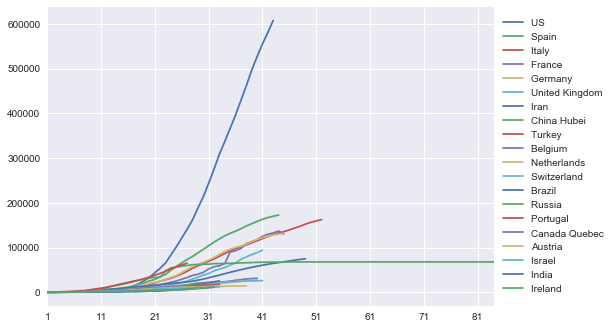

In [22]:
lineplot(df_growth_sorted, 20)

---

# EXPERIMENTATION AND DRAFT

In [23]:
def savitzky_golay_filter(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which which is the filtered input dataframe
    
    Description:
    In the derivative for a timeseries, datapoint x is the differences of point x and x-1 from the input array.
    '''

    df_output=df.copy()
    
    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
        
        value_list=[]
        
        # Iterate over all columns
        for col_name, col_data in df.iteritems():
            if col_name!='Infections' and not(np.isnan(df_output.at[index, col_name])):
                value_list.append(df_output.at[index, col_name])
        
        if len(value_list) >= 5:
            value_list=savgol_filter(value_list, 5, 2)

        value_liste_iterator=iter(value_list)
        
        # Iterate over all columns
        for col_name, col_data in df.iteritems():
            if col_name!='Infections' and not(np.isnan(df_output.at[index, col_name])):
                df_output.at[index, col_name]=next(value_liste_iterator)                
                
    return df_output
    

In [24]:
df_growth_sorted_filtered=savitzky_golay_filter(df_growth_sorted)

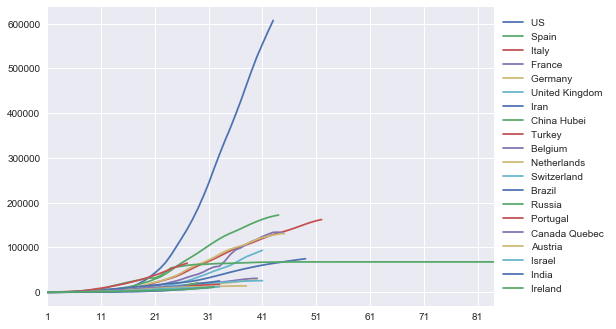

In [25]:
lineplot(df_growth_sorted_filtered, 20)

In [26]:
def derivative(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which represents a derivative of the input dataframe
    
    Description:
    In the derivative for a timeseries, datapoint x is the differences of point x and x-1 from the input array.
    '''

    df_output=df.copy()
    
    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
    
        # Iterate over all columns
        increase=0
        last_col_name=0
        for col_name, col_data in df.iteritems():
            if col_name!='Infections':
                if last_col_name != 0:
                    df_output.at[index, col_name]=df.at[index, col_name]-df.at[index, last_col_name]
                    last_col_name=col_name
                else:
                    df_output.at[index, col_name]=0
                    last_col_name=col_name
        
    return df_output


In [27]:
df_derivative=derivative(df_growth_sorted_filtered)

In [28]:
df_derivative.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Infections
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,0.0,26.314286,54.171429,80.571429,111.800000,90.542857,160.657143,272.628571,366.485714,393.657143,475.714286,577.914286,753.742857,1264.657143,1147.000000,2748.942857,4562.742857,6123.428571,6182.228571,8200.314286,9584.000000,10351.057143,12996.628571,16462.600000,18940.085714,19056.457143,19623.485714,22002.000000,24335.971429,27169.542857,29202.685714,32703.857143,31602.857143,29997.914286,28517.914286,30563.657143,31637.314286,33926.228571,33096.571429,31506.971429,27632.742857,26989.942857,25671.228571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,607670.0
Spain,0.0,28.542857,53.114286,73.428571,95.742857,118.771429,190.057143,408.400000,623.971429,208.371429,1060.028571,1662.171429,1874.714286,1407.771429,1858.314286,1885.542857,2665.400000,2968.542857,3803.857143,3520.485714,4916.971429,4634.000000,6791.828571,7915.628571,8987.657143,7851.142857,7346.200000,7243.400000,7552.942857,8099.000000,8152.657143,7835.400000,7407.171429,6596.828571,5711.400000,4991.200000,5536.657143,5706.114286,5454.828571,4934.085714,4636.228571,3955.800000,3192.228571,2455.085714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172541.0
Italy,0.0,59.400000,101.400000,138.457143,194.371429,204.971429,343.885714,414.542857,449.057143,430.428571,612.542857,694.685714,890.885714,1164.028571,1617.914286,1414.200000,1755.800000,858.857143,2191.714286,3217.742857,4434.457143,3303.371429,3349.742857,3499.600000,4286.800000,5215.457143,6143.114286,6276.800000,5627.628571,5023.428571,4969.485714,5540.000000,5863.142857,6151.314286,5837.457143,5116.885714,4223.485714,4149.428571,4572.600000,4719.600000,4695.057143,4677.028571,4324.228571,3529.142857,3294.942857,3699.371429,4048.942857,4290.257143,4406.942857,4084.542857,3393.628571,2767.485714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162488.0
France,0.0,30.942857,49.514286,46.457143,140.600000,244.971429,284.085714,142.971429,230.171429,462.971429,313.142857,525.000000,902.142857,692.971429,817.628571,1207.685714,1544.257143,1319.600000,1731.228571,1776.914286,1517.600000,2372.600000,2904.485714,3024.171429,2951.200000,3610.085714,4301.857143,3725.400000,3367.600000,4802.857143,6443.571429,4861.085714,1643.457143,11385.485714,14600.628571,10560.514286,4764.542857,7816.342857,6268.571429,4744.657143,6159.828571,5001.942857,4452.085714,262.800000,-2790.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136779.0
Germany,0.0,-7.371429,51.342857,101.571429,179.714286,184.657143,179.228571,167.714286,195.314286,302.514286,225.142857,682.657143,1003.600000,1263.228571,1099.085714,1471.685714,2162.857143,2683.171429,3685.914286,3545.200000,2998.085714,2812.057143,3716.714286,4035.000000,4769.171429,6155.228571,7226.228571,6222.542857,5102.857143,4418.342857,5142.085714,6050.371429,6778.685714,6290.857143,5088.400000,3850.657143,3525.971429,4364.942857,5260.742857,5069.800000,3815.914286,3098.628571,2677.457143,2094.857143,1576.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131359.0


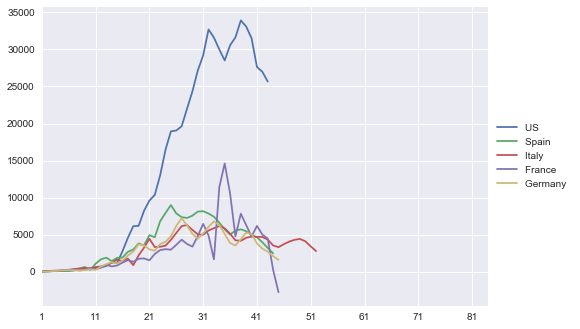

In [29]:
lineplot(df_derivative, 5)

In [30]:
df_2nd_derivative=derivative(df_derivative)

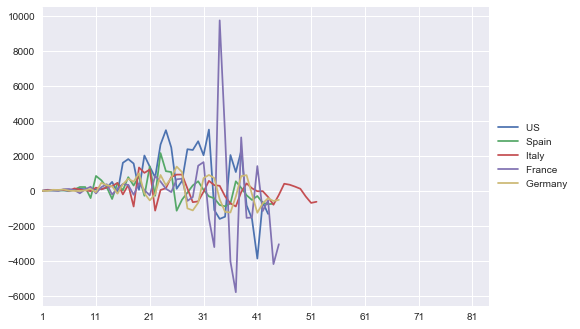

In [31]:
lineplot(df_2nd_derivative, 5)

In [32]:
def add_max_value_and_index(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which represents a derivative of the input dataframe
    
    Description:
    In the derivative for a timeseries, datapoint x is the differences of point x and x-1 from the input array.
    '''

    df_output=df.copy()
    
    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
        
        value_list=[]
        
        # Iterate over all columns
        for col_name, col_data in df.iteritems():
            if col_name!='Infections' and not(np.isnan(df_output.at[index, col_name])):
                value_list.append(df_output.at[index, col_name])

        max_value = max(value_list)
        max_index = value_list.index(max_value)
        
        df_output.at[index, 'max_value'] = max_value
        df_output.at[index, 'max_index'] = max_index

    return df_output

In [33]:
df_2nd_derivative=add_max_value_and_index(df_2nd_derivative)

In [34]:
df_2nd_derivative['growth_factor']=(df_2nd_derivative['max_value']/100)**(1/df_2nd_derivative['max_index'])

In [35]:
df_2nd_derivative

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,Infections,max_value,max_index,growth_factor
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,0.0,26.314286,2.785714e+01,26.400000,31.228571,-21.257143,70.114286,1.119714e+02,9.385714e+01,27.171429,82.057143,102.200000,175.828571,510.914286,-117.657143,1.601943e+03,1813.800000,1560.685714,58.800000,2.018086e+03,1383.685714,7.670571e+02,2.645571e+03,3.465971e+03,2.477486e+03,1.163714e+02,567.028571,2378.514286,2333.971429,2833.571429,2033.142857,3501.171429,-1101.000000,-1604.942857,-1480.000000,2045.742857,1073.657143,2288.914286,-829.657143,-1589.600000,-3.874229e+03,-642.800000,-1318.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,607670.0,3501.171429,31.0,1.121536
Spain,0.0,28.542857,2.457143e+01,20.314286,22.314286,23.028571,71.285714,2.183429e+02,2.155714e+02,-415.600000,851.657143,602.142857,212.542857,-466.942857,450.542857,2.722857e+01,779.857143,303.142857,835.314286,-2.833714e+02,1396.485714,-2.829714e+02,2.157829e+03,1.123800e+03,1.072029e+03,-1.136514e+03,-504.942857,-102.800000,309.542857,546.057143,53.657143,-317.257143,-428.228571,-810.342857,-885.428571,-720.200000,545.457143,169.457143,-251.285714,-520.742857,-2.978571e+02,-680.428571,-763.571429,-737.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172541.0,2157.828571,22.0,1.149839
Italy,0.0,59.400000,4.200000e+01,37.057143,55.914286,10.600000,138.914286,7.065714e+01,3.451429e+01,-18.628571,182.114286,82.142857,196.200000,273.142857,453.885714,-2.037143e+02,341.600000,-896.942857,1332.857143,1.026029e+03,1216.714286,-1.131086e+03,4.637143e+01,1.498571e+02,7.872000e+02,9.286571e+02,927.657143,133.685714,-649.171429,-604.200000,-53.942857,570.514286,323.142857,288.171429,-313.857143,-720.571429,-893.400000,-74.057143,423.171429,147.000000,-2.454286e+01,-18.028571,-352.800000,-795.085714,-234.200000,404.428571,3.495714e+02,2.413143e+02,116.685714,-322.400000,-6.909143e+02,-6.261429e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162488.0,1332.857143,18.0,1.154750
France,0.0,30.942857,1.857143e+01,-3.057143,94.142857,104.371429,39.114286,-1.411143e+02,8.720000e+01,232.800000,-149.828571,211.857143,377.142857,-209.171429,124.657143,3.900571e+02,336.571429,-224.657143,411.628571,4.568571e+01,-259.314286,8.550000e+02,5.318857e+02,1.196857e+02,-7.297143e+01,6.588857e+02,691.771429,-576.457143,-357.800000,1435.257143,1640.714286,-1582.485714,-3217.628571,9742.028571,3215.142857,-4040.114286,-5795.971429,3051.800000,-1547.771429,-1523.914286,1.415171e+03,-1157.885714,-549.857143,-4189.285714,-3053.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136779.0,9742.028571,33.0,1.148847
Germany,0.0,-7.371429,5.871429e+01,50.228571,78.142857,4.942857,-5.428571,-1.151429e+01,2.760000e+01,107.200000,-77.371429,457.514286,320.942857,259.628571,-164.142857,3.726000e+02,691.171429,520.314286,1002.742857,-1.407143e+02,-547.114286,-1.860286e+02,9.046571e+02,3.182857e+02,7.341714e+02,1.386057e+03,1071.000000,-1003.685714,-1119.685714,-684.514286,723.742857,908.285714,728.314286,-487.828571,-1202.457143,-1237.742857,-324.685714,838.971429,895.800000,-190.942857,-1.253886e+03,-717.285714,-421.171429,-582.600000,-518.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na